In [1]:
# lab_pca.ipynb
# Original (in MATLAB) by Carl Tape, GEOS 627, Inverse Problems and Parameter Estimation
# Translated by Darren Tan
#
# The goal of this tutorial is to establish/review the connections among
# eigendecomposition, singular value decomposition, principal component
# analysis, covariance matrix, correlation matrix, etc.
#
# TWO KEY OPERATIONS TO THE COLUMNS OF THE DATA MATRIX
# (1) centered: subtract mean
# (2) standardized (or scaled): divide by the standard deviation

# Download sklearn
!pip install sklearn

# Import necessary packages
import numpy as np
from scipy import linalg as LA
from scipy.spatial.distance import cdist
from scipy.stats import zscore
from sympy.matrices import Matrix
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing
from scipy.stats import zscore
from lib_geos import *

In [2]:
from load_pca_data import load_pca_data

# Load data
# idata = 1: City ratings data
# idata = 2: Protein consumption data
idata = 1
X, dlabs, dlabslong, vlabs, vlabslong, ndata, nparm = load_pca_data(idata)

City ratings data loaded (idata=1)
329 observations, 9 variables


City ratings data loaded (idata=1)
329 observations, 9 variables


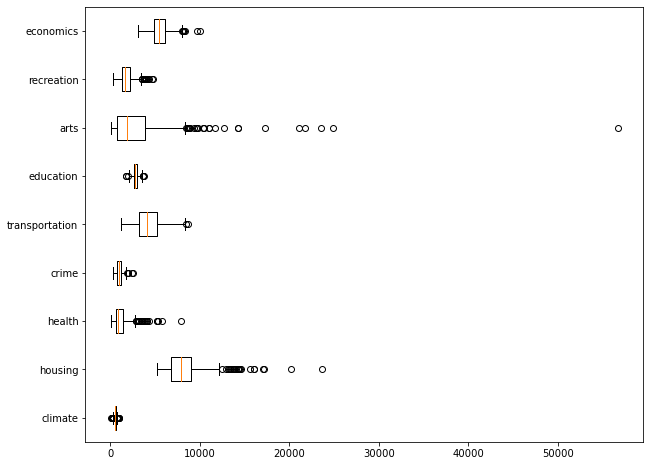

In [3]:
#==========================================================================
### PART 1: MATLAB tutorial
# https://www.mathworks.com/help/stats/quality-of-life-in-u-s-cities.html

# Load data
# idata = 1: City ratings data
# idata = 2: Protein consumption data
idata = 1
X, dlabs, dlabslong, vlabs, vlabslong, ndata, nparm = load_pca_data(idata)

# Make a boxplot to look at the distribution of the protein consumption data
plt.figure(figsize=(10,8))
plt.boxplot(X,vert=False,labels=vlabslong)
plt.show()

In [4]:
C = np.corrcoef(X,rowvar=False)
s = np.std(X,axis=0,ddof=1)
w = 1/s  # this differs from w in MATLAB code -- we implement weights manually 
W = np.tile(w,(ndata,1))
Xprime = X*W
pca = PCA()
pca.fit(Xprime)
coefforth = pca.components_.T  # 
wcoeff = (np.tile(s.flatten(),(nparm,1))*LA.inv(coefforth)).T  # wcoeff from MATLAB weighted PCA
score = pca.fit_transform(Xprime)  # score
latent = np.reshape(pca.explained_variance_, (nparm,1))  # latent
cscores = zscore(X,ddof=1)@coefforth
# how to get tsquared?
explained = pca.explained_variance_ratio_ * 100

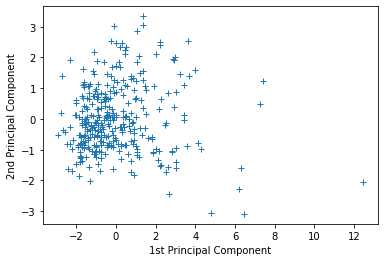

In [5]:
# visualizing the results
plt.figure()
plt.plot(score[:,0],score[:,1],'+')
plt.xlabel('1st Principal Component')
plt.ylabel('2nd Principal Component')
plt.show()

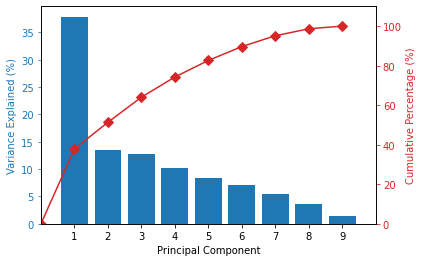

In [6]:
fig, ax = plt.subplots()
ax.bar(range(1,nparm+1),explained, color='C0')
ax.set_xlim([0,10])
ax.set_xticks(range(1,nparm+1))
ax.tick_params(axis='y', colors='C0')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Variance Explained (%)',color='C0')
ax2 = ax.twinx()
ax2.plot(range(0,nparm+1),[0, *list(np.cumsum(explained))], color="C3", marker="D", ms=7)
ax2.set_ylim([0,110])
ax2.tick_params(axis='y', colors='C3')
ax2.set_ylabel('Cumulative Percentage (%)', color='C3')
plt.show()

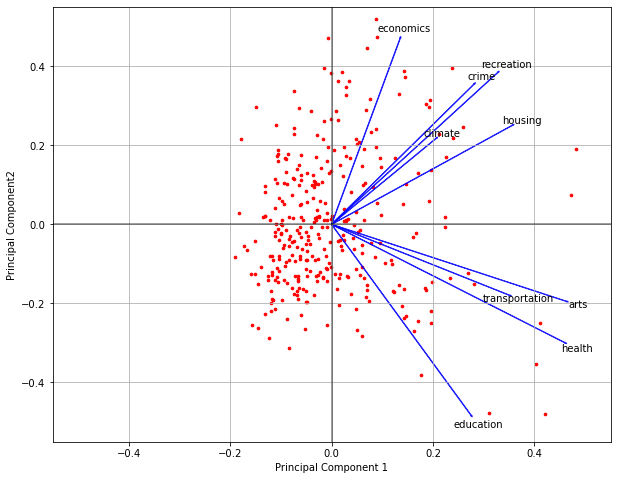

In [7]:
# Create biplot function similar to MATLAB's
def create_biplot(score,coeff,labels=None):
    plt.figure(figsize=(10,8))
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.axvline(0,color='k',alpha=0.5)
    plt.axhline(0,color='k',alpha=0.5)
    plt.scatter(xs * scalex,ys * scaley,s=7, color='red')
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1], color='blue', alpha=0.8)
        if labels is None:
            plt.text(coeff[i,0]*1.05, coeff[i,1]*1.05, "Var"+str(i+1), color='k', ha='center', va='center')
        else:
            plt.text(coeff[i,0]*1.05, coeff[i,1]*1.05, labels[i], color='k', ha='center', va='center')
    plt.xlabel("Principal Component {}".format(1))
    plt.ylabel("Principal Component{}".format(2))
    plt.grid()

# Create biplot for first two principal components
create_biplot(score[:,0:2],np.transpose(coefforth.T[0:2, :]),vlabslong)
plt.xlim([-0.55,0.55])
plt.ylim([-0.55,0.55])
plt.show()

Protein consumption data loaded (idata=2)
25 observations, 9 variables


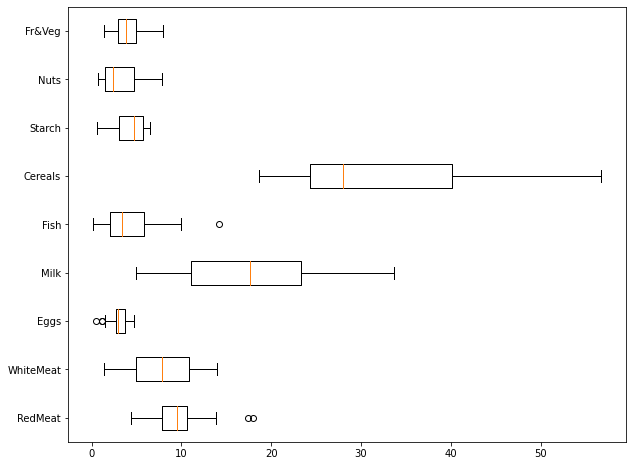

In [8]:
#==========================================================================
### PART 2

# Load data
# idata = 1: City ratings data
# idata = 2: Protein consumption data
idata = 2
X, dlabs, dlabslong, vlabs, vlabslong, ndata, nparm = load_pca_data(idata)

# Make a boxplot to look at the distribution of the protein consumption data
plt.figure(figsize=(10,8))
plt.boxplot(X,vert=False,labels=vlabslong)
plt.show()

In [9]:
# Exploring relationships among eig, cov, svd, pca, etc
# from wiki: http://en.wikipedia.org/wiki/Principal_component_analysis

### REMOVE THE MEAN FOR EACH COLUMN
u = np.mean(X,axis=0)  # dimensionless vector
u = np.reshape(u,(1,len(u)))  # row vector
h = np.ones((ndata,1))  # column vector
# Craft the centered matrix
B = X - h@u;

### COVARIANCE MATRIX
C = (1/(ndata-1)) * (B.T @ B)  
# LA.norm(C-np.cov(B,rowvar=False)) / LA.norm(C) # check
# LA.norm(C-np.cov(X,rowvar=False)) / LA.norm(C) # check

# standard deviations of each column of X
s = np.sqrt(np.diag(C))  # dimensionless vector
s = np.reshape(s, (1,len(s)))  # row vector
# s = np.sqrt(np.var(X, axis=0, ddof=1))) # alternative

# important: np.sqrt and np.var differ from MATLAB's sqrt and var 
# due to default setting of ddof=0

# check for sigma1
Cdiag = np.diag(np.diag(C))
hCdiag = LA.sqrtm(Cdiag)
# print([np.std(X[:,0], ddof=1), hCdiag[0][0]]) # check
# print([np.var(X[:,0], ddof=1), Cdiag[0][0]]) # check

### CORRELATION MATRIX (is a scaled covariance matrix)
# # Define function to convert covariance matrix to correlation matrix
# def corrcov(C):
#     nx,ny = C.shape
#     if nx != ny:
#         return
#     sigma = np.sqrt(np.diag(C))
#     outer_v = np.outer(sigma,sigma)
#     Crho = C / outer_v
#     Crho[C == 0] = 0
#     return Crho
# R = np.corrcoef(X, rowvar=False) # alternative
# R = np.corrcoef(B, rowvar=False) # alternative
# R = corrcov(C) # alternative
# R = C/(s.T @ s) # alternative
# R = np.diag(1/s.flatten()) @ C @ np.diag(1/s.flatten()) # alternative
R = LA.inv(hCdiag) @ C @ LA.inv(hCdiag)
# Ccheck = hCdiag @ R @ hCdiag # check
# LA.norm(Ccheck - C) / LA.norm(C) # check

### STANDARDIZED (AND CENTERED) MATRIX
# Z = B / (h@s) # alternative
# Z = B @ np.diag(1/s.flatten()) # alternative
Z = B @ LA.inv(hCdiag)
# LA.norm(Z - zscore(X,ddof=1)) / LA.norm(Z) # check
# Bcheck = Z * (h@s) # check reverse
# LA.norm(B-Bcheck) / LA.norm(B) # check reverse

### EIGENVALUE DECOMPOSITION
eigvalC, Vc = LA.eig(C)
Dc = np.real(np.diag(eigvalC))
# LA.norm(C@Vc - Vc@Dc) / LA.norm(C@Vc) # check
## if needed: sort eigenvalues and rearrange V
isort = np.argsort(eigvalC)[::-1] # [::-1] flips the array
Vc = Vc[:,isort]
Dc = np.diag(eigvalC[isort])
# LA.norm(C@Vc - Vc@Dc) / LA.norm(C@Vc) # check
eigvalC = eigvalC[isort]  # dimensionless
eigvalC = np.reshape(eigvalC,(nparm,1))  # column vector

eigvalR, Vr = LA.eig(R)
Dr = np.real(np.diag(eigvalR))
isort = np.argsort(eigvalR)[::-1] # [::-1] flips the array
Vr = Vr[:,isort]
Dr = np.diag(eigvalR[isort])
# LA.norm(R@Vr - Vr@Dr) / LA.norm(R@Vr) # check
eigvalR = eigvalR[isort]  # dimensionless
eigvalR = np.reshape(eigvalR,(nparm,1))  # column vector
# Vr @ Dr @ Vr.T
# LA.inv(hCdiag) @ Vc @ Dc @ (LA.inv(hCdiag) @ Vc).T

In [10]:
experiment = False

if experiment:
    # experiment with multiplying each column of A by a factor
    A = np.random.rand(8,3)
    s = np.sqrt(np.var(A, axis=0, ddof=1))  # dimensionless
    s = np.reshape(s,(1,3))  # row vector
    h = np.ones((8,1))  # column vector
    print('A = \n', A)
    # this looks like dividing each column by its standard deviation
    ans = A / (h@s)
    print('A / (h@s) = \n', ans)
    ans = A / np.tile(s,(8,1))
    print('A / np.tile(s,(8,1)) = \n', ans)
    # this is the series of elemetary matrix operations
    ans = A @ np.diag([1/s[0,0],1,1]) @ np.diag([1,1/s[0,1],1]) @ np.diag([1,1,1/s[0,2]])
    # this is what it means
    ans = A @ np.diag(1/s.flatten())
    print('A @ np.diag(1/s.flatten()) = \n', ans)

In [11]:
print('mean(X) = \n',np.mean(X,axis=0))
print('mean(B) = \n',np.mean(B,axis=0))
print('mean(Z) = \n',np.mean(Z,axis=0))
print('\n')
print('var(X) = \n',np.var(X,axis=0,ddof=1))
print('var(B) = \n',np.var(B,axis=0,ddof=1))
print('var(Z) = \n',np.var(Z,axis=0,ddof=1))
print('\n')
print('std(X) = \n',np.std(X,axis=0,ddof=1))
print('std(B) = \n',np.std(B,axis=0,ddof=1))
print('std(Z) = \n',np.std(Z,axis=0,ddof=1))

mean(X) = 
 [ 9.828  7.896  2.936 17.112  4.284 32.248  4.276  3.072  4.136]
mean(B) = 
 [-1.24344979e-15  1.06581410e-15 -3.81916720e-16 -1.49213975e-15
  2.84217094e-16 -4.40536496e-15 -6.39488462e-16 -4.26325641e-16
 -9.76996262e-16]
mean(Z) = 
 [-3.55271368e-16  3.01980663e-16 -3.73034936e-16 -2.30926389e-16
  5.32907052e-17 -4.26325641e-16 -3.81916720e-16 -2.48689958e-16
 -5.46229728e-16]


var(X) = 
 [ 11.20293333  13.64623333   1.24906667  50.48693333  11.57723333
 120.44593333   2.67023333   3.94293333   3.25406667]
var(B) = 
 [ 11.20293333  13.64623333   1.24906667  50.48693333  11.57723333
 120.44593333   2.67023333   3.94293333   3.25406667]
var(Z) = 
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]


std(X) = 
 [ 3.34707833  3.69408085  1.11761651  7.10541577  3.40253337 10.97478625
  1.63408486  1.98568208  1.80390318]
std(B) = 
 [ 3.34707833  3.69408085  1.11761651  7.10541577  3.40253337 10.97478625
  1.63408486  1.98568208  1.80390318]
std(Z) = 
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [12]:
### SINGULAR VALUE DECOMPOSITION of B
# the scores matrix is nothing more than U@S from the SVD
Ub,Sb,Vb = svdmat(B)
svalb = np.diag(Sb)  # dimensionless
svalb = np.reshape(svalb,(nparm,1))  # column vector
USb = Ub@Sb
# check singular values with eigenvalues of covariance matrix
# LA.norm(np.square(svalb)/(ndata-1) - eigvalC) / LA.norm(eigvalC)
# check: Vb = Vc. Use abs() to allow for sign flips
# abs(Vc) - abs(Vb)

### SINGULAR VALUE DECOMPOSITION of Z
# Vz = Vr (allowing sign changes)
Uz,Sz,Vz = svdmat(Z)
svalz = np.diag(Sz)  # dimensionless
svalz = np.reshape(svalz,(nparm,1))  # column vector
USz = Uz@Sz
# check singular values with eigenvalues of correlation matrix
# LA.norm(np.square(svalz)/(ndata-1) - eigvalR) / LA.norm(eigvalR)

In [13]:
### Test 1: Use centered matrix
# VB = Vb = Vc (allowing for some sign flips on columns of V)
# USB = Ub@Sb
# pcvarB = eigvalC
pca = PCA()
pca.fit(B)
VB = pca.components_.T  # coeff
USB = pca.fit_transform(B)  # score
pcvarB = np.reshape(pca.explained_variance_, (nparm,1))  # latent
# this is equivalent, since pca will center the matrix (i.e., remove mean)
# pca = PCA()
# pca.fit(X)
# V = pca.components_.T  # coeff
# US = pca.fit_transform(X)  # score

# Bcheck = USB @ VB.T
# LA.norm(B-Bcheck) / LA.norm(B)
# # orthonormal
# LA.norm(VB.T @ VB - np.eye(nparm))
# US1_check = B @ VB
# LA.norm(USB - US1_check) / LA.norm(USB)

In [14]:
### Test 2 (example used in matlab)
# note: this gives different US and V from Test 1
w = 1/s  # this differs from w in MATLAB code -- we implement weights manually
W = np.tile(w,(ndata,1))
Bprime = B*W
pca = PCA()
pca.fit(Bprime)
Vw_not_orthonormal = pca.components_.T  # 
Vw = (np.tile(s.flatten(),(nparm,1))*LA.inv(Vw_not_orthonormal)).T  # wcoeff from MATLAB weighted PCA
USw = pca.fit_transform(Bprime)  # score
pcvarBw = np.reshape(pca.explained_variance_, (nparm,1))  # latent

# % this is equivalent
# %[Vw,USw] = pca(B,'VariableWeights','variance')
# Bcheck = USw * Vw';
# norm(B - Bcheck) / norm(B)
# disp('Vw is NOT orthornomal:');
# norm(Vw'*Vw - eye(nparm))
# Vworth = inv(hCdiag)*Vw;   % note: inv(hCdiag) = diag(1./s)
# % orthonormal:
# norm(Vworth'*Vworth - eye(nparm))
# % this shows how USw can be computed
# USw_check = Z*Vworth;
# norm(USw - USw_check) / norm(USw)

In [15]:
### Test 3: Use centered+standardized matrix as input
# VZ = Vz = Vr = LA.inv(hCdiag)@Vw  (allowing for sign flips)
# USZ = USw (allowing for sign flips)
# pcvarZ = eigvalR
pca = PCA()
pca.fit(Z)
VZ = pca.components_.T  # coeff
USZ = pca.fit_transform(Z)  # score
pcvarZ = np.reshape(pca.explained_variance_, (nparm,1))  # latent

# Zcheck = USZ @ VZ.T
# LA.norm(Z-Zcheck) / LA.norm(Z)
# Bcheck = USZ @ VZ.T @ hCdiag
# LA.norm(B-Bcheck) / LA.norm(B)
# # orthonormal
# LA.norm(VZ.T @ VZ - np.eye(nparm))
# VZ_check = LA.inv(hCdiag)@Vw
# LA.norm(VZ - VZ_check) / VZ.norm(USB)

In [16]:
#==============================
# tips for the lab exercise (lab_pca.m)

# cumulative variance
for kk in range(2):
    if kk == 0:
        pcvar = pcvarB
        stlab = 'centered'
    else:
        pcvar = pcvarZ
        stlab = 'centered+standardized'
    propvar = pcvar/np.sum(pcvar)
    # from the matlab tutorial: explained = 100*cpropvar (idata=1)
    cpropvar = np.cumsum(propvar)
    print('\n')
    print('Importance of principal components [%s]' % stlab)
    print('Std-Dev  : sqrt( eigenvalues of the covariance (or correlation) matrix of X )')
    print('Prop-Var : proportion of variance')
    print('Std-Dev  : cumulative proportion of variance')
    print('----------------------------------------------')
    print('PC#\tStd-Dev\t\tVar\t\tProp-Var\tCum-Prop')
    for i in range(nparm):
        print('%d\t%f\t%f\t%f\t%f' % (i+1,np.sqrt(pcvar[i]),pcvar[i],propvar[i],cpropvar[i]))



Importance of principal components [centered]
Std-Dev  : sqrt( eigenvalues of the covariance (or correlation) matrix of X )
Prop-Var : proportion of variance
Std-Dev  : cumulative proportion of variance
----------------------------------------------
PC#	Std-Dev		Var		Prop-Var	Cum-Prop
1	12.459294	155.233995	0.710533	0.710533
2	5.540644	30.698737	0.140513	0.851046
3	3.955181	15.643457	0.071603	0.922649
4	2.883909	8.316930	0.038068	0.960717
5	1.905235	3.629922	0.016615	0.977331
6	1.558458	2.428791	0.011117	0.988448
7	1.247717	1.556798	0.007126	0.995574
8	0.845458	0.714799	0.003272	0.998846
9	0.502134	0.252139	0.001154	1.000000


Importance of principal components [centered+standardized]
Std-Dev  : sqrt( eigenvalues of the covariance (or correlation) matrix of X )
Prop-Var : proportion of variance
Std-Dev  : cumulative proportion of variance
----------------------------------------------
PC#	Std-Dev		Var		Prop-Var	Cum-Prop
1	2.001609	4.006438	0.445160	0.445160
2	1.278671	1.634999	0.1816

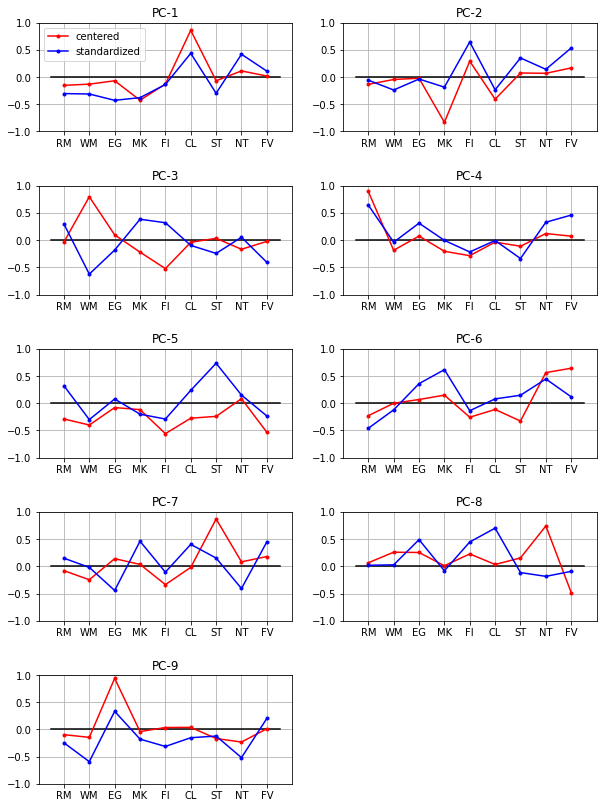

In [17]:
# plot components
fig=plt.figure(figsize=(10,14))
for ii in range(nparm):
    plt.subplot(5,2,ii+1)
    plt.plot([0.5,nparm+0.5],[0,0],'k')
    h1 = plt.plot(range(1,nparm+1),VB[:,ii],'r.-',label='centered')
    h2 = plt.plot(range(1,nparm+1),VZ[:,ii],'b.-',label='standardized')
    plt.axis([0,nparm+1,-1,1])
    plt.title('PC-%d' % (ii+1))
    plt.xticks(range(1,nparm+1),labels=vlabs)
    plt.grid()
    if ii == 0:
        plt.legend()
        plt.subplots_adjust(wspace=0.2,hspace=0.5)